## ELAN Evaluation metrics (Dim delta, depth, alpha, Dim consistency)

In [39]:
from library.ron_utils import *
import matplotlib.pyplot as plt
from ELAN_label_trackID import tracking_obj_by_labels
from ELAN_EVAL import evaluation

'''
cam_to_img = np.array([
        [ 1.418667e+03, 0.000000e+00, 6.4e+02,0],
        [ 0.000000e+00, 1.418667e+03, 3.6e+02,0],
        [ 0.000000e+00, 0.000000e+00, 1.000000e+00,0]])
'''

def ELAN_eval_metrics(result_root):
    valset = [x.strip() for x in open('Elan_3d_box/ImageSets/val.txt').readlines()]
    dim_GT = list()
    dim_ELAN = list()
    depth_GT = list()
    depth_ELAN = list()
    alpha_GT = list()
    alpha_ELAN = list()
    #set_ = set()
    for id_ in valset:
        gt_lines = [x.strip() for x in open(f'Elan_3d_box/renew_label_obj/{id_}.txt').readlines()]
        gt_objects = [TrackingObject(line) for line in gt_lines if line.split()[0].lower()=='car']
        
        for obj in gt_objects:
            #set_.add(obj.id)
            dim_GT.append(obj.dims[0])
            depth_GT.append(obj.locs[0][2])
            alpha_GT.append(obj.alphas[0])
            
        pred_lines = [x.strip() for x in open(f'{result_root}/label_2/{id_}.txt').readlines()]
        pred_objects = [TrackingObject(line) for line in pred_lines if line.split()[0].lower()=='car']
        for obj in pred_objects:
            dim_ELAN.append(obj.dims[0])
            depth_ELAN.append(obj.locs[0][2])
            alpha_ELAN.append(obj.alphas[0])
    
    #print('OBJECT NUM', len(set_))
    #print(set_)
    dim_GT = np.array(dim_GT)
    dim_ELAN = np.array(dim_ELAN)
    depth_GT = np.array(depth_GT)
    depth_ELAN = np.array(depth_ELAN)
    alpha_GT = np.array(alpha_GT)
    alpha_ELAN = np.array(alpha_ELAN)

    depth_diff = depth_GT-depth_ELAN
    alpha_diff = np.cos(alpha_GT - alpha_ELAN)
    dim_diff = np.mean(abs(dim_GT-dim_ELAN), axis=0)
    print(f'[DIM diff] H:{dim_diff[0]:.4f}, W:{dim_diff[1]:.4f}, L:{dim_diff[2]:.4f}')
    
    print(f'[Alpha diff] abs_mean: {1-alpha_diff.mean():.4f}')
    plt.hist(alpha_diff)
    plt.show()
    print(f'[Depth diff] abs_mean: {abs(depth_diff).mean():.4f}')
    print('[Depth error]')
    box_depth_error_calculation(depth_GT, depth_ELAN, 5)

ImportError: cannot import name 'iou_2d' from 'library.ron_utils' (/data/ron/elan_project/library/ron_utils.py)

In [ ]:
# BL_IMAGENET BL_ELAN
# video_IMAGENET video_ELAN
date = '0720/'
N0_folders = ['BL_B4_N0', 'V_dim_B4_N0', 'V_alpha_B4_N0', 'V_dim_alpha_B4_N0']
N1_folders = ['BL_B4_N1', 'V_dim_B4_N1', 'V_alpha_B4_N1', 'V_dim_alpha_B4_N1']
is_group = False
for f in N0_folders:
    tmp_f = date + f
    if is_group:
        tmp_f += '_G_W10'
    print(f'========{tmp_f}========')
    ELAN_eval_metrics(tmp_f)
    print()


In [ ]:
from library.ron_utils import *
def get_covex_box(box1, box2):
    box1 = np.array(box1, dtype=np.int32).flatten()
    box2 = np.array(box2, dtype=np.int32).flatten()
    x1 = min(box1[0], box2[0]) # left
    y1 = min(box1[1], box2[1]) # top
    x2 = max(box1[2], box2[2]) # right
    y2 = max(box1[3], box2[3]) # btm
    return x1, y1, x2, y2
#
def calc_DIoU_2d(box1, box2):
    center_X1, center_Y1 = get_box_center(box1)
    center_X2, center_Y2 = get_box_center(box2)
    print(center_X1, center_X1, center_X2, center_Y2)
    cX1, cY1, cX2, cY2 = get_covex_box(box1, box2)
    d_square = (center_X1-center_X2)**2 + (center_Y1-center_Y2)**2
    print(d_square)
    c_square = (cX1-cX2)**2 + (cY1-cY2)**2
    print(c_square)
    DIoU = calc_GIoU_2d(box1, box2) - d_square/c_square
    return DIoU

def calc_CIoU_2d(box1, box2):
    w1, h1 = get_box_size(box1)
    w2, h2 = get_box_size(box2)
    gamma = 4/(np.pi**2) * (np.arctan(w1/h1) - np.arctan(w2/h2))**2
    alpha = gamma / (1 - calc_IoU_2d(box1, box2) - gamma)
    DIoU = calc_DIoU_2d(box1, box2)
    print(alpha)
    print(gamma)
    print(alpha*gamma)
    CIoU = DIoU - alpha*gamma
    return CIoU

#calc_CIoU_2d(box_2d, prj_box)

GIOU
0.9122823475198315
DIOU
920 920 919 207
5
9409
0.9117509414192895
CIOU
920 920 919 207
5
9409
0.0041651379038417004
0.00035852290146533457
1.4932973262885682e-06
0.9117494481219632


### IOU 和 GIOU算起來的都一樣,因為都是大框(REG)包住小框(GT)的情形

### IoU_loss = -ln(IoU), GIoU_loss = 1-GIoU
* [IOU大集合](https://zhuanlan.zhihu.com/p/359982543)

## Elan Proj box and 2d box IOU calculateion

In [ ]:
def elan_plot_3d_box(img, cam_to_img, ry, dimension, center, thickness=3, shift=[27, 0]): #影像有黑邊，畫上去的時候要位移黑邊的pixel數，我是向右位移27個

    # plot_3d_pts(img, [center], center, calib_file=calib_file, cam_to_img=cam_to_img)

    R = rotation_matrix(ry)

    corners = create_corners(dimension, location=center, R=R)

    # to see the corners on image as red circles
    # plot_3d_pts(img, corners, center,cam_to_img=cam_to_img, relative=False)

    box_3d = []
    for corner in corners:
        point = project_3d_pt(corner, cam_to_img)
        point += shift
        #print(point)
        box_3d.append(point)
    #print('-'*20)
    cv2.line(img, (box_3d[0][0], box_3d[0][1]), (box_3d[2][0],box_3d[2][1]), cv_colors.GREEN.value, thickness)
    cv2.line(img, (box_3d[4][0], box_3d[4][1]), (box_3d[6][0],box_3d[6][1]), cv_colors.GREEN.value, thickness)
    cv2.line(img, (box_3d[0][0], box_3d[0][1]), (box_3d[4][0],box_3d[4][1]), cv_colors.GREEN.value, thickness)
    cv2.line(img, (box_3d[2][0], box_3d[2][1]), (box_3d[6][0],box_3d[6][1]), cv_colors.GREEN.value, thickness)

    cv2.line(img, (box_3d[1][0], box_3d[1][1]), (box_3d[3][0],box_3d[3][1]), cv_colors.GREEN.value, thickness)
    cv2.line(img, (box_3d[1][0], box_3d[1][1]), (box_3d[5][0],box_3d[5][1]), cv_colors.GREEN.value, thickness)
    cv2.line(img, (box_3d[7][0], box_3d[7][1]), (box_3d[3][0],box_3d[3][1]), cv_colors.GREEN.value, thickness)
    cv2.line(img, (box_3d[7][0], box_3d[7][1]), (box_3d[5][0],box_3d[5][1]), cv_colors.GREEN.value, thickness)

    for i in range(0,7,2):
        cv2.line(img, (box_3d[i][0], box_3d[i][1]), (box_3d[i+1][0],box_3d[i+1][1]), cv_colors.GREEN.value, thickness)

    front_mark = [(box_3d[i][0], box_3d[i][1]) for i in range(4)]

    cv2.line(img, front_mark[0], front_mark[3], cv_colors.BLUE.value, thickness)
    cv2.line(img, front_mark[1], front_mark[2], cv_colors.BLUE.value, thickness)

GT [ 0.64        0.99499995 21.4       ] CALC [ 0.59  0.97 21.24]
GT [3.55  0.915 9.34 ] CALC [3.4  0.84 9.02]


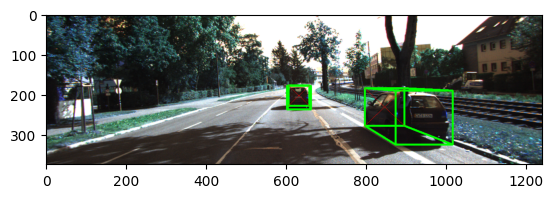

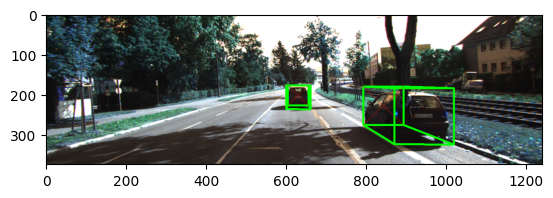

GT [ 2.15        0.91499996 14.83      ] CALC [ 2.13  0.91 14.81]
GT [-5.87       1.1800001 17.52     ] CALC [-5.67  1.08 16.91]
GT [ 1.08        0.79499996 21.88      ] CALC [ 1.07  0.76 21.95]
GT [-1.31   1.125 33.9  ] CALC [-1.35  1.11 34.41]
GT [-3.48   1.165 43.72 ] CALC [-3.51  1.13 43.98]


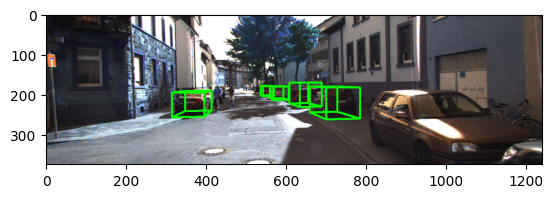

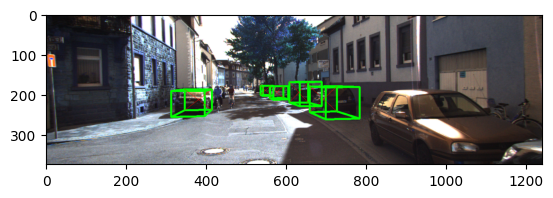

GT [-3.68  1.22 45.59] CALC [-3.66  1.14 44.97]


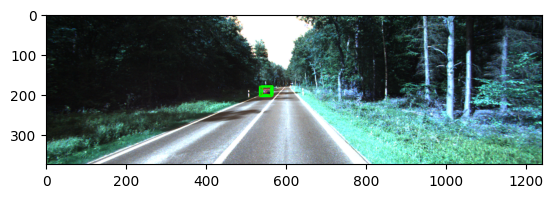

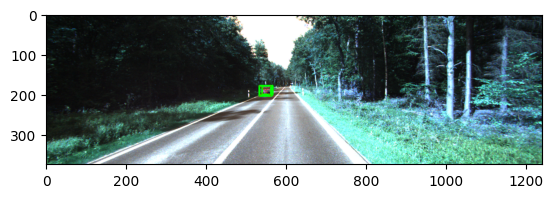

GT [-16.83    2.405  53.36 ] CALC [-16.84   2.34  53.25]


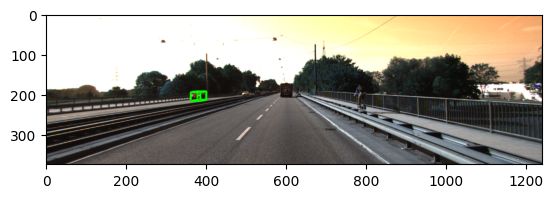

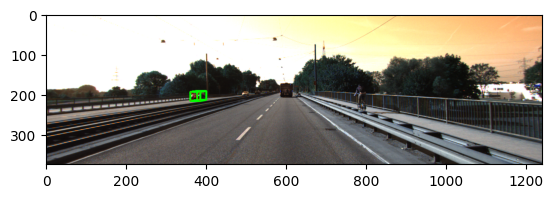

GT [ 0.2        1.1700001 45.16     ] CALC [ 0.15  1.13 45.16]
GT [-12.69        1.4300001  25.       ] CALC [-12.65   1.41  24.87]


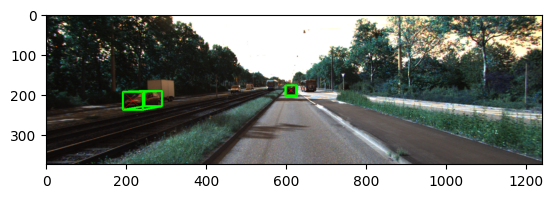

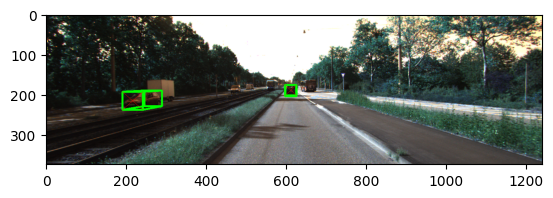

In [ ]:
from torch_lib.KITTI_Dataset import Object3d, FrameCalibrationData
from library.ron_utils import *
import glob, os, re
import cv2
import matplotlib.pyplot as plt
# weights/0830_Adam/Elan_BL_B4_N1_50.pkl
# IVA_scenario_data_NCTU/day-rain
#rons_folder = '0830_Adam/Elan_3d_box/BL_B4_N1'
'''
ELAN_cam_to_img = np.array([
            [1.418667e+03, 0.000e+00, 6.4e+02, 0],
            [0.000e+00, 1.418867e+03, 3.6e+02, 0],
            [0.000e+00, 000e+00, 1.0e+00, 0] ])
'''


cls_list = ['car']
diff_list = [1, 2]
#images = sorted(glob.glob('Elan_3d_box/image_2/*.png'))
#labels = sorted(glob.glob('Elan_3d_box/renew_label/*.txt'))
images = sorted(glob.glob('Kitti/training/image_2/*.png'))
labels = sorted(glob.glob('Kitti/training/label_2/*.txt'))
calibs = sorted(glob.glob('Kitti/training/calib/00????.txt'))

reg_labels = sorted(glob.glob('0922_ln_iou_1/KITTI_BL_B4_aug_vgg/*.txt'))

for i in range(200,205):#len(zzys_labels)):
    objects = [Object3d(line) for line in open(labels[i]).readlines()]
    img = cv2.imread(images[i])
    calc_img = np.copy(img)
    cam_to_img = FrameCalibrationData(calibs[i]).p2
    for obj in objects:
        #class_ = obj.cls_type
        if obj.cls_type in cls_list and obj.level in diff_list:
            #truncation = obj.truncation
            #occlusion = obj.occlusion
            alpha = obj.alpha
            ry = obj.ry
            gt_box2d = obj.box2d
            dim = obj.dim
            loc = obj.pos
            loc[1] -= dim[0]/2
            theta_ray = calc_theta_ray(img.shape[1], gt_box2d, cam_to_img)
            #cv2.rectangle(img, (obj.box2d[0], obj.box2d[1]), (obj.box2d[2], obj.box2d[3]), (255,0,0), 2)
            gt_prj_box = loc3d_2_box2d_np(ry, loc, dim, cam_to_img)
            gt_prj_box[0] += 27
            gt_prj_box[2] += 27 #elan data right shift 27
            calc_loc, _ = calc_location(dim, cam_to_img, gt_box2d, alpha, theta_ray)
            calc_loc = np.round(calc_loc, 2)
            calc_prj_box = loc3d_2_box2d_np(ry, calc_loc, dim, cam_to_img)
            #calc_prj_box[0] += 27
            #calc_prj_box[2] += 27 #elan data right shift 27
            #print('GT', loc, 'CALC', calc_loc)

            #cv2.rectangle(img, (obj.box2d[0], obj.box2d[1]), (obj.box2d[2], obj.box2d[3]), (255,0,0), 2)
            #cv2.rectangle(img, (gt_prj_box[0], gt_prj_box[1]), (gt_prj_box[2], gt_prj_box[3]), (0,0,255), 2)
            #cv2.rectangle(img, (calc_prj_box[0], calc_prj_box[1]), (calc_prj_box[2], calc_prj_box[3]), (0,255,0), 2)
            #print(calc_IoU_2d(gt_prj_box, calc_prj_box))
            #elan_plot_3d_box(img, cam_to_img, ry, dim, calc_loc)
            plot_3d_box(img, cam_to_img, ry, dim, loc)
            plot_3d_box(calc_img, cam_to_img, ry, dim, calc_loc)

    plt.imshow(img)
    plt.show()
    plt.imshow(calc_img)
    plt.show()


# Train one epoch trial with all Loss

In [1]:
from torch_lib.KITTI_Dataset import *
from torch_lib.Model_heading_bin import *
from library.ron_utils import *
import torch
import torch.nn.functional as F
from torchvision.models import vgg
from torch.utils import data
from torchvision import transforms
import time

cfg = {'path':'Kitti/training',
            'class_list':['car'], 'diff_list': [1, 2], #0:DontCare, 1:Easy, 2:Moderate, 3:Hard, 4:Unknown
            'bins': 4, 'cond':False, 'group':False, 'network':0}
keep_same_seeds(2023)
device = torch.device(f'cuda:0') # 選gpu的index
batch_size = 4 #16 #64 worse than 8
W_dim = 1 #0.1~0.14
W_theta = 1 #0.03~1
W_group = 0.6 # 0.02
W_consist = 1 #數值小0.02~0.04  TODO W_consist要調高(0818) tried bad:3,5
W_angle = 0.1 #數值大0.05~0.2
W_iou = 1 # 數值大0.3~0.5 0919:0.2
W_depth = 0.05 # 2
# make weights folder
bin_num = cfg['bins']
# model
print("Loading all detected objects in dataset...")
print('Kitti dataset')
process = transforms.Compose([transforms.ToTensor(), 
                            transforms.Resize([224,224], transforms.InterpolationMode.BICUBIC), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset_train = KITTI_Dataset(cfg, process, split='train')
dataset_valid = KITTI_Dataset(cfg, process, split='val')
params = {'batch_size': batch_size,
            'shuffle': False,
            'num_workers': 6}

train_loader = data.DataLoader(dataset_train, **params)
valid_loader = data.DataLoader(dataset_valid, **params)
angle_per_class=2*np.pi/float(bin_num)

#grad會斷掉 連不到bin_L, residual
def new_compute_ry(bin, residual, theta_rays, angle_per_class): 
    bin_argmax = torch.max(bin, dim=1)[1]
    residual = residual[torch.arange(len(residual)), bin_argmax]
    one_hot = torch.zeros((residual).shape).to(device)
    # make one hot map
    for i in range(bin.shape[0]):
        one_hot[i][bin[i]] = 1
    reg_residual = torch.sum(residual * one_hot.to(device), axis=1)
    angles = angle_per_class*bin_argmax + residual #mapping bin_class and residual to get alpha
    for a, ray in zip(angles, theta_rays):
        angles = angle_correction(a+ray)
    return angles

'''
    one_hot = torch.zeros((residual).shape).to(device)
    # make one hot map
    for i in range(gt_bin.shape[0]):
        if gt_bin[i] >= residual.shape[1] or gt_bin[i] < 0:
            print(gt_bin)
        one_hot[i][gt_bin[i]] = 1
    reg_residual = torch.sum(residual * one_hot.to(device), axis=1)
    residual_loss = F.l1_loss(reg_residual, gt_residual, reduction=reduction)
    return residual_loss
'''

/home/ron/anaconda3/envs/elan_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading all detected objects in dataset...
Kitti dataset
Load Right Images
Load Right Images


'\n    one_hot = torch.zeros((residual).shape).to(device)\n    # make one hot map\n    for i in range(gt_bin.shape[0]):\n        if gt_bin[i] >= residual.shape[1] or gt_bin[i] < 0:\n            print(gt_bin)\n        one_hot[i][gt_bin[i]] = 1\n    reg_residual = torch.sum(residual * one_hot.to(device), axis=1)\n    residual_loss = F.l1_loss(reg_residual, gt_residual, reduction=reduction)\n    return residual_loss\n'

In [7]:
def init_loss_dict():
    loss_dict = dict()
    # org
    loss_dict['total'] = 0 
    loss_dict['dim'] = 0
    loss_dict['bin'] = 0
    loss_dict['residual'] = 0
    loss_dict['theta'] = 0 # theta = bin+residual
    # mine
    loss_dict['group'] = 0
    loss_dict['C_dim'] = 0
    loss_dict['C_angle'] = 0
    loss_dict['depth'] = 0
    loss_dict['iou'] = 0
    return loss_dict

def loss_dict_add(loss_dict, batch_size, bin, residual, dim, total, group, consist_dim, consist_angle, depth, iou): #.item()
    # org
    loss_dict['total'] += total*batch_size
    loss_dict['dim'] += dim*batch_size
    loss_dict['bin'] += bin*batch_size
    loss_dict['residual'] += residual*batch_size
    loss_dict['theta'] = loss_dict['bin'] + loss_dict['theta']
    # mine
    loss_dict['group'] += group*batch_size
    loss_dict['C_dim'] += consist_dim*batch_size
    loss_dict['C_angle'] += consist_angle*batch_size
    loss_dict['depth'] += depth*batch_size
    loss_dict['iou'] += iou*batch_size
    return loss_dict

def calc_avg_loss(loss_dict, total_num): #len(dataset_train_all)
    for key in loss_dict.keys():
        loss_dict[key] /= total_num
    return loss_dict

def print_epoch_loss(loss_dict, epoch, type='Train'): #len(dataset_train_all)
    print(f'--- epoch {epoch} {type}---', end=' ')
    for key in loss_dict.keys():
        if key == 'group': # for better observation
            print()
            print('\t\t\t', end='')
        print(f'[{key}:{loss_dict[key]:.3f}]', end=', ')
    print()

In [8]:
from library.ron_utils import *
from library.Math_tensor import *
import time
is_depth = 1
is_iou = 1

keep_same_seeds(2023)
my_vgg = vgg.vgg19_bn(weights='DEFAULT') #512x7x7
model = vgg_Model(features=my_vgg.features, bins=bin_num).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
start = time.time()
print('total_batches',  len(train_loader), 'total_num', len(dataset_train))
weight_dict = {'dim':1, 'theta':1, 'group': 0.1, 'C_dim':1, 'C_angle':0.2, 'depth':0.05, 'iou':0.2}

for epoch in range(2):
    
    model.train()
    train_loss_dict = init_loss_dict()
    for batch_L, labels_L, batch_R, labels_R in train_loader:
        optimizer.zero_grad()
        batch_L=batch_L.to(device)
        batch_R=batch_R.to(device)
        gt_residual = labels_L['Heading_res'].to(device)
        gt_bin = labels_L['Heading_bin'].to(device)#這個角度在哪個class上
        gt_dim = labels_L['Dim_delta'].to(device)
        gt_theta_ray_L = labels_L['Theta_ray'].to(device)
        gt_theta_ray_R = labels_R['Theta_ray'].to(device)
        gt_depths = labels_L['Depth'].to(device)
        gt_alphas = labels_L['Alpha'].to(device)
        gt_img_W = labels_L['img_W'] #depth_loss
        gt_box2d = labels_L['Box2d'] #depth_loss
        gt_calib = labels_L['Calib'].numpy() #depth_loss, iou_loss
        gt_trun = labels_L['Truncation'] #depth_loss
        
        [residual_L, bin_L, dim_L] = model(batch_L)

        bin_loss = weight_dict['theta'] * F.cross_entropy(bin_L, gt_bin, reduction='mean').to(device)
        residual_loss = weight_dict['theta'] * compute_residual_loss(residual_L, gt_bin, gt_residual, device)        
        #dim_loss = F.mse_loss(dim, gt_dim, reduction='mean')  # org use mse_loss
        dim_loss = weight_dict['dim'] * F.l1_loss(dim_L, gt_dim, reduction='mean')  # 0613 added (monodle, monogup used) (compare L1 vs mse loss)
        #dim_loss = W_dim * L1_loss_alpha(dim_L, gt_dim, GT_alphas, device) # 0613 try elevate dim performance       
        #dim_loss = W_dim * F.mse_loss(dim_L, gt_dim, reduction='mean').to(device) # 0613 try elevate dim performance
    
        with torch.no_grad(): #0817 added
            [residual_R, bin_R, dim_R] = model(batch_R)
        C_dim_loss = weight_dict['C_dim'] * F.l1_loss(dim_L, dim_R, reduction='mean').to(device)
        #reg_ry_L = new_compute_ry(bin_L, residual_L, gt_theta_ray_L, angle_per_class) #grad會斷掉 連不到bin_L, residual
        #reg_ry_R = compute_ry(bin_R, residual_R, gt_theta_ray_R, angle_per_class).to(device)
        #C_angle_loss = Weight_dict['C_angle'] * F.l1_loss(torch.cos(reg_ry_L), torch.cos(reg_ry_R), reduction='mean').to(device)
        C_angle_loss = weight_dict['C_angle'] * torch.tensor(0.0).to(device)

        # group_loss TODO verify backward
        group_loss = weight_dict['group'] * torch.tensor(0.0).to(device)

        reg_alphas = compute_alpha(bin_L, residual_L, angle_per_class)
        reg_dims = torch.tensor(dataset_train.get_cls_dim_avg('car')).to(device) + dim_L
        #gt_dims = torch.tensor(dataset_train.get_cls_dim_avg('car')).to(device) + gt_dim
        depth_loss = torch.tensor(0.0).to(device)
        st = time.time()
        if is_depth > 0:
            obj_W, obj_L = reg_dims[:,1], reg_dims[:,2]
            if is_depth==1:
                depth_alphas = reg_alphas #dep
            elif is_depth==2:
                depth_alphas = gt_alphas #depA            
            calc_depths = calc_depth_with_alpha_theta_tensor(gt_img_W, gt_box2d, gt_calib, obj_W, obj_L, depth_alphas, gt_trun, device)
            depth_loss = weight_dict['depth'] * F.l1_loss(calc_depths, gt_depths, reduction='mean')

        iou_loss = torch.tensor(0.0).to(device)
        if is_iou > 0:
            if is_iou == 1:
                iou_alphas = reg_alphas
            elif is_iou == 2:
                iou_alphas =  torch.tensor(gt_alphas)
            #iou_alphas = reg_alphas if is_iou==1 else torch.tensor(gt_alphas)
            iou_loss = weight_dict['iou'] * calc_IoU_loss_tensor(gt_box2d, gt_theta_ray_L, reg_dims.cpu(), iou_alphas, gt_calib, device) #iou

        total_loss = dim_loss + bin_loss + residual_loss + group_loss \
                    + C_dim_loss + C_angle_loss + depth_loss + iou_loss
        train_loss_dict = loss_dict_add(train_loss_dict, batch_L.shape[0], bin_loss.item(), residual_loss.item(), dim_loss.item(), total_loss.item(), \
                                group_loss.item(), C_dim_loss.item(), C_angle_loss.item(), depth_loss.item(), iou_loss.item()) #.item()        
        
        total_loss.backward()
        #a = list(model.parameters())[-1].clone()
        optimizer.step()
        #b = list(model.parameters())[-1].clone()
        #print('IS EQUAL?', torch.equal(a.data, b.data))

    train_loss_dict = calc_avg_loss(train_loss_dict, len(dataset_train))
    print_epoch_loss(train_loss_dict, epoch, type='Train')
    
    model.eval()
    val_loss_dict = init_loss_dict()
    VAL_alpha_list = list()
    VAL_dim_list = list()
    VAL_reg_alpha_list = list()
    VAL_reg_dim_list = list()
    with torch.no_grad():
        for val_batch_L, val_labels_L, val_batch_R, val_labels_R in valid_loader:
            val_batch_L=val_batch_L.to(device)
            val_batch_R=val_batch_R.to(device)
            val_residual = val_labels_L['Heading_res'].to(device)
            val_bin = val_labels_L['Heading_bin'].to(device)#這個角度在哪個class上
            val_dim = val_labels_L['Dim_delta'].to(device)
            val_theta_ray_L = val_labels_L['Theta_ray'].numpy()
            val_theta_ray_R = val_labels_R['Theta_ray'].to(device)
            val_depths = val_labels_L['Depth'] #val compute on cpu
            val_alphas = val_labels_L['Alpha'].to(device)
            val_img_W = val_labels_L['img_W'] #depth_loss
            val_box2d = val_labels_L['Box2d'].numpy() #depth_loss, tensor->numpy
            val_calib = val_labels_L['Calib'].numpy() #depth_loss, iou_loss
            val_trun = val_labels_L['Truncation'] #depth_loss
            
            [residual, bin, dim] = model(val_batch_L)
            [residual_r, bin_r, dim_r] = model(val_batch_R)

            val_dim_loss = weight_dict['dim'] * F.l1_loss(dim, val_dim, reduction='mean')
            val_bin_loss = weight_dict['theta'] * F.cross_entropy(bin, val_bin, reduction='mean').to(device)
            val_residual_loss = weight_dict['theta'] * compute_residual_loss(residual, val_bin, val_residual, device)
            
            val_C_dim_loss = weight_dict['C_dim'] * F.l1_loss(dim, dim_r, reduction='mean').to(device)
            val_C_angle_loss = weight_dict['C_angle'] * torch.tensor(0.0).to(device)

            #TODO grouploss
            val_group_loss = weight_dict['group'] * torch.tensor(0.0).to(device)

            # 1008 depth_loss
            val_depth_loss = torch.tensor(0.0).to(device)
            val_reg_alphas = compute_alpha(bin, residual, angle_per_class)
            val_reg_dims = dataset_train.get_cls_dim_avg('car') + dim.cpu().detach().numpy()
            #val_dims = torch.tensor(dataset_train.get_cls_dim_avg('car')).to(device) + val_dim
            if is_depth > 0:
                calc_depths = list()
                for i in range(val_batch_L.shape[0]):
                    img_W, box2d, cam_to_img = val_img_W[i], val_box2d[i], val_calib[i]
                    _, obj_W, obj_L = val_reg_dims[i]
                    if is_depth==1:
                        depth_alpha = val_reg_alphas[i].cpu() #dep
                    elif is_depth==2:
                        depth_alpha = val_alphas[i].to(device) #depA 
                    calc_depths.append(calc_depth_with_alpha_theta(img_W, box2d, cam_to_img, obj_W, obj_L, depth_alpha, trun=val_trun[i]))
                calc_depths = torch.stack(calc_depths)
                val_depth_loss = weight_dict['depth'] * F.l1_loss(calc_depths, val_depths, reduction='mean')
            
            val_iou_loss = torch.tensor(0.0).to(device)
            if is_iou > 0:
                # one take 1.38s (iou_loss = W_iou * calc_IoU_loss_tensor(gt_box2d, gt_theta_ray_L, reg_dims, reg_alphas, gt_calib, device)
                # faster computation ? Yes, 0.05s
                if is_iou == 1:
                    iou_alphas = val_reg_alphas.cpu().detach().numpy()
                elif is_iou == 2:
                    iou_alphas = val_alphas
                val_iou_loss = weight_dict['iou'] * calc_IoU_loss(val_box2d, val_theta_ray_L, val_reg_dims, iou_alphas, val_calib).to(device)

            val_total_loss = val_dim_loss + val_bin_loss + val_residual_loss + val_group_loss + \
                            val_C_dim_loss + val_C_angle_loss + val_depth_loss + val_iou_loss
            val_loss_dict = loss_dict_add(val_loss_dict, val_batch_L.shape[0], val_bin_loss.item(), val_residual_loss.item(), val_dim_loss.item(), val_total_loss.item(), \
                                        val_group_loss.item(), val_C_dim_loss.item(), val_C_angle_loss.item(), val_depth_loss.item(), val_iou_loss.item()) #.item()

            VAL_reg_alpha_list += val_reg_alphas.cpu().tolist()
            VAL_alpha_list += val_alphas.cpu().tolist()
            VAL_reg_dim_list += dim.cpu().tolist()
            VAL_dim_list += val_dim.cpu().tolist()

        val_loss_dict = calc_avg_loss(val_loss_dict, len(dataset_valid))
        print_epoch_loss(val_loss_dict, epoch, type='Valid')

        eval_angle_diff = angle_criterion(VAL_reg_alpha_list, VAL_alpha_list)
        VAL_dim_list = np.array(VAL_dim_list)
        VAL_reg_dim_list = np.array(VAL_reg_dim_list)
        eval_dim_diff =  np.mean(abs(VAL_dim_list-VAL_reg_dim_list), axis=0)
        print(f'[Alpha diff]: {eval_angle_diff:.4f}') #close to 0 is better
        print(f'[DIM diff] H:{eval_dim_diff[0]:.4f}, W:{eval_dim_diff[1]:.4f}, L:{eval_dim_diff[2]:.4f}')
        '''record
        writer.add_scalar(f'{train_config}/alpha_diff', eval_angle_diff, epoch)
        writer.add_scalar(f'{train_config}/H_diff', eval_dim_diff[0], epoch)
        writer.add_scalar(f'{train_config}/W_diff', eval_dim_diff[1], epoch)
        writer.add_scalar(f'{train_config}/L_diff', eval_dim_diff[2], epoch)
        for key in train_loss_dict.keys():
            writer.add_scalars(f'{train_config}/{key}_loss', {'Train': train_loss_dict[key], 'Valid': val_loss_dict[key]}, epoch)
        '''

'''
        a = list(model.parameters())[-1].clone()
        optimizer.step()
        b = list(model.parameters())[-1].clone()
        print('IS EQUAL?', torch.equal(a.data, b.data))
        print('model grad:', list(model.parameters())[-1].grad)
'''

total_batches 2039 total_num 8155
--- epoch 0 Train--- [total:1.369], [dim:0.184], [bin:0.673], [residual:0.199], [theta:861.019], 
			[group:0.000], [C_dim:0.034], [C_angle:0.000], [depth:0.210], [iou:0.070], 
--- epoch 0 Valid--- [total:0.796], [dim:0.167], [bin:0.266], [residual:0.167], [theta:266.976], 
			[group:0.000], [C_dim:0.007], [C_angle:0.000], [depth:0.121], [iou:0.068], 
[Alpha diff]: 0.1496
[DIM diff] H:0.0981, W:0.0801, L:0.3230
--- epoch 1 Train--- [total:0.744], [dim:0.180], [bin:0.181], [residual:0.170], [theta:212.943], 
			[group:0.000], [C_dim:0.016], [C_angle:0.000], [depth:0.131], [iou:0.066], 
--- epoch 1 Valid--- [total:0.691], [dim:0.167], [bin:0.181], [residual:0.151], [theta:181.938], 
			[group:0.000], [C_dim:0.005], [C_angle:0.000], [depth:0.121], [iou:0.067], 
[Alpha diff]: 0.1261
[DIM diff] H:0.0981, W:0.0795, L:0.3219


"\n        a = list(model.parameters())[-1].clone()\n        optimizer.step()\n        b = list(model.parameters())[-1].clone()\n        print('IS EQUAL?', torch.equal(a.data, b.data))\n        print('model grad:', list(model.parameters())[-1].grad)\n"

In [6]:
def record_loss(writer, train_loss_dict, val_loss_dict, train_config):
    for key in train_loss_dict.keys():
        writer.add_scalars(f'{train_config}/{key}_loss', {'Train': train_loss_dict[key], 'Valid': val_loss_dict[key]}, epoch)

torch.Tensor

## Visualize IoU loss 3d box

In [2]:
# call it when using Object3D.generate_corners3d()
def my_plot_3d_box(corners_3d, cam_to_img, img, color=(0,255,0)):
    pt_3d = list()
    for corner in corners_3d:
        point = project_3d_pt(corner, cam_to_img)
        #cv2.circle(img, point, (i+1)*2, (255,0,0), -1)
        pt_3d.append(point)
    #btm
    for i in range(0,4): 
        #btm
        cv2.line(img, pt_3d[i], pt_3d[(i+1)%4], color, 2)
        #top
        cv2.line(img, pt_3d[4+i], pt_3d[4+(i+1)%4], color, 2)
        #vertical
        cv2.line(img, pt_3d[i], pt_3d[i+4], color, 2)
    #front
    cv2.line(img, pt_3d[0], pt_3d[5], (255,0,0), 2)
    cv2.line(img, pt_3d[1], pt_3d[4], (255,0,0), 2)

def loc3d_2_box2d(orient, location, dimension, cam_to_img):
    prj_points = []
    R = np.array([[np.cos(orient), 0, np.sin(orient)], [0, 1, 0], [-np.sin(orient), 0, np.cos(orient)]])
    corners = create_corners(dimension, location, R)
    for corner in corners:
        point = project_3d_pt(corner, cam_to_img)
        prj_points.append(point)

    prj_points = np.array(prj_points)
    prj_points_X = prj_points[:,0]
    prj_points_Y = prj_points[:,1]
    prj_box = [min(prj_points_X), min(prj_points_Y), max(prj_points_X), max(prj_points_Y)]
    prj_box = np.array(prj_box, dtype=np.int32)
    return prj_box

def calc_IoU_2d(box1, box2):
    box1 = np.array(box1, dtype=np.int32).flatten()
    box2 = np.array(box2, dtype=np.int32).flatten()
    area1 = (box1[2]-box1[0])*(box1[3]-box1[1])
    area2 = (box2[2]-box2[0])*(box2[3]-box2[1])
    area_sum = abs(area1) + abs(area2)
    
    #計算重疊方形座標
    x1 = max(box1[0], box2[0]) # left
    y1 = max(box1[1], box2[1]) # top
    x2 = min(box1[2], box2[2]) # right
    y2 = min(box1[3], box2[3]) # btm

    if x1 >= x2 or y1 >= y2:
        return 0
    else:
        area_overlap = abs((x2-x1)*(y2-y1))

    area_union = area_sum-area_overlap
    return area_overlap/area_union

In [31]:
import glob
import cv2
from library.Plotting import *
import matplotlib.pyplot as plt
import numpy as np
from torch_lib.KITTI_Dataset import Object3d, FrameCalibrationData

image_folder = 'Kitti/training/image_2'
gt_folder = 'Kitti/training/label_2'
bl_folder = '0928_BL/KITTI_BL_B4_vgg'
iou_folder = '1009_iou/KITTI_BL_B4_iou_vgg'
iouA_folder = '1009_iou/KITTI_BL_B4_iouA_vgg' #not done yet
iouA_folder = '1009_iou/KITTI_BL_B4_iou_vgg'
train_ids = [x.strip() for x in open('Kitti/ImageSets/train.txt').readlines()]
val_ids = [x.strip() for x in open('Kitti/ImageSets/val.txt').readlines()]

#'000008'
BL_iou = list()
IOU_iou = list()
IOUA_iou = list()
for id_ in train_ids:
    cam_to_img= FrameCalibrationData(f'Kitti/training/calib/{id_}.txt').p2
    img = cv2.cvtColor(cv2.imread(f'{image_folder}/{id_}.png'), cv2.COLOR_BGR2RGB)
    gt_img = np.copy(img)
    bl_img = np.copy(img)
    iou_img = np.copy(img)

    gt_objects = [Object3d(line) for line in open(f'{gt_folder}/{id_}.txt').readlines()]
    bl_objects = [Object3d(line) for line in open(f'{bl_folder}/{id_}.txt').readlines()]
    iou_objects = [Object3d(line) for line in open(f'{iou_folder}/{id_}.txt').readlines()]
    iouA_objects = [Object3d(line) for line in open(f'{iouA_folder}/{id_}.txt').readlines()]
    #print(len(gt_objects), len(bl_objects), len(iou_objects))
    index=0
    for i in range(len(gt_objects)):
        if (gt_objects[i].level == 1 or gt_objects[i].level == 2) and gt_objects[i].cls_type.lower() == 'car':
            gt_o = gt_objects[i]
            bl_o = bl_objects[index]
            iou_o = iou_objects[index]
            iouA_o = iouA_objects[index]
            gt_box2d = gt_o.box2d
            gt_box2d = gt_o.box2d # == others 因為當初label生成用GT
            
            #cv2.rectangle(gt_img, (gt_box2d[0], gt_box2d[1]), (gt_box2d[2], gt_box2d[3]), (255,0,0), 2)
            #cv2.rectangle(bl_img, (gt_box2d[0], gt_box2d[1]), (gt_box2d[2], gt_box2d[3]), (0,255,0), 2)
            #cv2.rectangle(iou_img, (gt_box2d[0], gt_box2d[1]), (gt_box2d[2], gt_box2d[3]), (0,0,255), 2)

            bl_pos = np.copy(bl_o.pos)
            bl_pos[1] -= bl_o.dim[0]/2 #移動到物體中心
            bl_prj_box2d = loc3d_2_box2d(bl_o.ry, bl_pos, bl_o.dim, cam_to_img)
            bl_iou = calc_IoU_2d(gt_box2d, bl_prj_box2d)

            iou_pos = np.copy(iou_o.pos)
            iou_pos[1] -= iou_o.dim[0]/2
            iou_prj_box2d = loc3d_2_box2d(iou_o.ry, iou_pos, iou_o.dim, cam_to_img)
            iou_iou = calc_IoU_2d(gt_box2d, iou_prj_box2d)

            iouA_pos = np.copy(iouA_o.pos)
            iouA_pos[1] -= iouA_o.dim[0]/2
            iouA_prj_box2d = loc3d_2_box2d(iouA_o.ry, iouA_pos, iouA_o.dim, cam_to_img)
            iouA_iou = calc_IoU_2d(gt_box2d, iouA_prj_box2d)


            BL_iou.append(bl_iou)
            IOU_iou.append(iou_iou)
            IOUA_iou.append(iouA_iou)
            index +=1
            '''
            gt_corners = gt_o.generate_corners3d()
            #my_plot_3d_box(gt_corners, cam_to_img, gt_img)
            bl_corners = bl_o.generate_corners3d()
            #my_plot_3d_box(bl_corners, cam_to_img, bl_img)
            iou_corners = iou_o.generate_corners3d()
            #my_plot_3d_box(iou_corners, cam_to_img, iou_img)
            
            cv2.putText(bl_img, f'{index}', (gt_box2d[0]//2+gt_box2d[2]//2, gt_box2d[1]//2+gt_box2d[3]//2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            cv2.rectangle(bl_img, (gt_box2d[0], gt_box2d[1]), (gt_box2d[2], gt_box2d[3]), (0,255,0), 2)
            cv2.rectangle(bl_img, (bl_prj_box2d[0], bl_prj_box2d[1]), (bl_prj_box2d[2], bl_prj_box2d[3]), (0,0,255), 2)
            cv2.rectangle(bl_img, (iou_prj_box2d[0], iou_prj_box2d[1]), (iou_prj_box2d[2], iou_prj_box2d[3]), (222,0,255), 2)
            print(f'[IOU] BL:{round(bl_iou,3)}, IOU:{round(iou_iou,3)}')
            print(f'[Depth] GT:{round(gt_o.pos[2],2)}, BL:{round(bl_o.pos[2],2)}, IOU:{round(iou_o.pos[2],2)}')
            print(f'[Alpha] GT:{gt_o.alpha}, BL:{bl_o.alpha}, IOU:{iou_o.alpha}')
            print(f'[W] GT:{gt_o.w}, BL:{bl_o.w}, IOU:{iou_o.w} | [L] GT:{gt_o.l}, BL:{bl_o.l}, IOU:{iou_o.l} | [H] GT:{gt_o.h}, BL:{bl_o.h}, IOU:{iou_o.h}')
            print()
            
    print('GT: Green, BL: Blue, IOU: Purple')
    if index!=0:
        plt.imshow(gt_img)
        plt.show()
        plt.imshow(bl_img)
        plt.show()
        plt.imshow(iou_img)
        plt.show()
    '''

In [12]:
BL_iou_mean = np.mean(BL_iou)
IOU_iou_mean = np.mean(IOU_iou)
print(BL_iou_mean, IOU_iou_mean) #[val] BL:IOU= 0.8066:0.7292, [train] BL:IOU= 0.8559:0.7352

0.8559153588718936 0.7352743819281784


## ELAN dataset IOU

In [33]:
# ELAN dataset
import cv2, glob
from library.Plotting import *
import matplotlib.pyplot as plt
import numpy as np
from torch_lib.KITTI_Dataset import Object3d, FrameCalibrationData

image_folder = 'Elan_3d_box_230808/image_2'
gt_folder = 'Elan_3d_box_230808/renew_label'
bl_folder = '1009_iou/Elan_3d_box_230808/BL_B4_N1/label_2'
iou_folder = '1009_iou/Elan_3d_box_230808/BL_B4_N1_iou/label_2'
iouA_folder = '1009_iou/Elan_3d_box_230808/BL_B4_N1_iouA/label_2'

all_labels = sorted(glob.glob('Elan_3d_box_230808/renew_label/*.txt'))
all_ids = [name.split('/')[-1].split('.')[0] for name in all_labels]
cam_to_img= np.array([
            [1.418667e+03, 0.000e+00, 6.4e+02, 0],
            [0.000e+00, 1.418867e+03, 3.6e+02, 0],
            [0.000e+00, 000e+00, 1.0e+00, 0] ])

BL_iou = list()
IOU_iou = list()
IOUA_iou = list()
for id_ in all_ids:
    
    img = cv2.cvtColor(cv2.imread(f'{image_folder}/{id_}.png'), cv2.COLOR_BGR2RGB)
    gt_img = np.copy(img)
    bl_img = np.copy(img)
    iou_img = np.copy(img)

    gt_objects = [Object3d(line) for line in open(f'{gt_folder}/{id_}.txt').readlines()]
    bl_objects = [Object3d(line) for line in open(f'{bl_folder}/{id_}.txt').readlines()]
    iou_objects = [Object3d(line) for line in open(f'{iou_folder}/{id_}.txt').readlines()]
    iouA_objects = [Object3d(line) for line in open(f'{iouA_folder}/{id_}.txt').readlines()]
    #print(len(gt_objects), len(bl_objects), len(iou_objects))
    index=0
    for i in range(len(gt_objects)):
        if (gt_objects[i].level == 1 or gt_objects[i].level == 2) and gt_objects[i].cls_type.lower() == 'car':
            gt_o = gt_objects[i]
            bl_o = bl_objects[index]
            iou_o = iou_objects[index]
            iouA_o = iouA_objects[index]
            gt_box2d = gt_o.box2d # == others 因為當初label生成用GT
            
            #cv2.rectangle(gt_img, (gt_box2d[0], gt_box2d[1]), (gt_box2d[2], gt_box2d[3]), (255,0,0), 2)
            #cv2.rectangle(bl_img, (gt_box2d[0], gt_box2d[1]), (gt_box2d[2], gt_box2d[3]), (0,255,0), 2)
            #cv2.rectangle(iou_img, (gt_box2d[0], gt_box2d[1]), (gt_box2d[2], gt_box2d[3]), (0,0,255), 2)
            bl_pos = np.copy(bl_o.pos)
            #bl_pos[1] -= bl_o.dim[0]/2 #不用移因為Elan的pos是中心
            bl_prj_box2d = loc3d_2_box2d_np(bl_o.ry, bl_pos, bl_o.dim, cam_to_img)
            bl_iou = calc_IoU_2d(gt_box2d, bl_prj_box2d)

            iou_pos = np.copy(iou_o.pos)
            iou_prj_box2d = loc3d_2_box2d_np(iou_o.ry, iou_pos, iou_o.dim, cam_to_img)
            iou_iou = calc_IoU_2d(gt_box2d, iou_prj_box2d)
            
            iouA_pos = np.copy(iouA_o.pos)
            iouA_prj_box2d = loc3d_2_box2d_np(iouA_o.ry, iouA_pos, iouA_o.dim, cam_to_img)
            iouA_iou = calc_IoU_2d(gt_box2d, iouA_prj_box2d)

            BL_iou.append(bl_iou)
            IOU_iou.append(iou_iou)
            IOUA_iou.append(iouA_iou)
            index +=1
            
            '''
            gt_corners = gt_o.generate_corners3d()
            #my_plot_3d_box(gt_corners, cam_to_img, gt_img)
            bl_corners = bl_o.generate_corners3d()
            #my_plot_3d_box(bl_corners, cam_to_img, bl_img)
            iou_corners = iou_o.generate_corners3d()
            #my_plot_3d_box(iou_corners, cam_to_img, iou_img)
            
            cv2.putText(bl_img, f'{index}', (gt_box2d[0]//2+gt_box2d[2]//2, gt_box2d[1]//2+gt_box2d[3]//2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            cv2.rectangle(bl_img, (gt_box2d[0], gt_box2d[1]), (gt_box2d[2], gt_box2d[3]), (0,255,0), 2)
            cv2.rectangle(bl_img, (bl_prj_box2d[0], bl_prj_box2d[1]), (bl_prj_box2d[2], bl_prj_box2d[3]), (0,0,255), 2)
            cv2.rectangle(bl_img, (iou_prj_box2d[0], iou_prj_box2d[1]), (iou_prj_box2d[2], iou_prj_box2d[3]), (222,0,255), 2)
            
            print(f'[IOU] BL:{round(bl_iou,3)}, IOU:{round(iou_iou,3)}')
            print(f'[Depth] GT:{round(gt_o.pos[2],2)}, BL:{round(bl_o.pos[2],2)}, IOU:{round(iou_o.pos[2],2)}')
            print(f'[Alpha] GT:{gt_o.alpha}, BL:{bl_o.alpha}, IOU:{iou_o.alpha}')
            print(f'[W] GT:{gt_o.w}, BL:{bl_o.w}, IOU:{iou_o.w} | [L] GT:{gt_o.l}, BL:{bl_o.l}, IOU:{iou_o.l} | [H] GT:{gt_o.h}, BL:{bl_o.h}, IOU:{iou_o.h}')
            print()
    print('GT: Green, BL: Blue, IOU: Purple')
    if index!=0:
        #plt.imshow(gt_img)
        #plt.show()
        plt.imshow(bl_img)
        plt.show()
        #plt.imshow(iou_img)
        #plt.show()
    '''


In [34]:
BL_iou_mean = np.mean(BL_iou)
IOU_iou_mean = np.mean(IOU_iou)
IOUA_iou_mean = np.mean(IOUA_iou)
print(BL_iou_mean, IOU_iou_mean, IOUA_iou_mean) #BL:IOU:IOUA= 0.7344:0.7787:0.7842

0.7344362659509259 0.7787844800650006 0.7842859864474688
